In [1]:
import sys
import os


module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([24.,])
)

domain_init_kwargs

{'xmin': array([0.]), 'xmax': array([24.])}

In [24]:
import jax.numpy as jnp
from fbpinns.problems import Problem
class SaturatedGrowthModel(Problem):
    """
    u' = u(C-u)
    I.C.
    u(0) = u_0 = 0.01
    """

    @staticmethod
    def init_params(C, u0, sd):
        
        static_params = {
            "dims":(1,1),
            "C_ture":C,
            "u_0":u0,
            "sd":sd,
        }
        trainable_params = {
            "C":jnp.array(0.), # learn C from constraints
        }

        return static_params, trainable_params
    
    @staticmethod 
    def exact_solution(all_params, x_batch, batch_shape=None):
        u0 = all_params["static"]["problem"]["u_0"]
        C = all_params["static"]["problem"]["C_ture"]

        exp = jnp.exp(-C*x_batch)
        u = C / (1 + ((C - u0) / u0) * exp)
        return u
    
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, ()),
            (0, (0,)),
        )

        # Data Loss
        #x_batch_data = jnp.linspace(0,24,15).astype(float).reshape((15,1)) #15 data observation
        x_batch_data = np.linspace(0, 10, 15).astype(float).reshape((15, 1))
        u_data = SaturatedGrowthModel.exact_solution(all_params, x_batch_data)
        required_ujs_data = (
            (0, ()),
        )
        return [[x_batch_phys, required_ujs_phys],
                [x_batch_data, u_data, required_ujs_data]]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        u0 = all_params["static"]["problem"]["u_0"]
        x, tanh = x_batch[:,0:1], jnp.tanh

        u = u0 + (tanh(x/sd)**2)*u #check u_t & u
        return u
    
    @staticmethod
    def loss_fn(all_params, constraints):

        C = all_params["trainable"]["problem"]["C"]
        # physics loss
        _, u, ut = constraints[0]
        phys = jnp.mean((ut - u*(C-u))**2)

        # data loss
        _, uc, u = constraints[1]
        data = 1e6*jnp.mean((u-uc)**2)

        # return phys + boundary + data
        return phys + data

problem = SaturatedGrowthModel
problem_init_kwargs = dict(
    C=1, u0=0.01, sd=0.2 # define the ode parameters
)
        

In [25]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND # use a rectangular domain decomposition

decomposition_init_kwargs = dict(
    subdomain_xs = [np.linspace(0,24,15)],
    subdomain_ws = [(24/12)*np.ones((15,))],
    unnorm = (0., 1.),
)
subdomain_xs = [np.linspace(0,24,15)]
subdomain_ws = [(24/12)*np.ones((15,))]
print(subdomain_xs)
print(subdomain_ws)

[array([ 0.        ,  1.71428571,  3.42857143,  5.14285714,  6.85714286,
        8.57142857, 10.28571429, 12.        , 13.71428571, 15.42857143,
       17.14285714, 18.85714286, 20.57142857, 22.28571429, 24.        ])]
[array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])]


In [26]:
from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,32,1],# with 2 hidden layers
)

In [30]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=60000,# number of training steps
    clear_output=True,
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([24.])}
problem: <class '__main__.SaturatedGrowthModel'>
problem_init_kwargs: {'C': 1, 'u0': 0.01, 'sd': 0.2}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([ 0.        ,  1.71428571,  3.42857143,  5.14285714,  6.85714286,
        8.57142857, 10.28571429, 12.        , 13.71428571, 15.42857143,
       17.14285714, 18.85714286, 20.57142857, 22.28571429, 24.        ])], 'subdomain_ws': [array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 60000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x00000226CF911120>
optimiser_kwargs: {'learning_rate': 0.001}
s

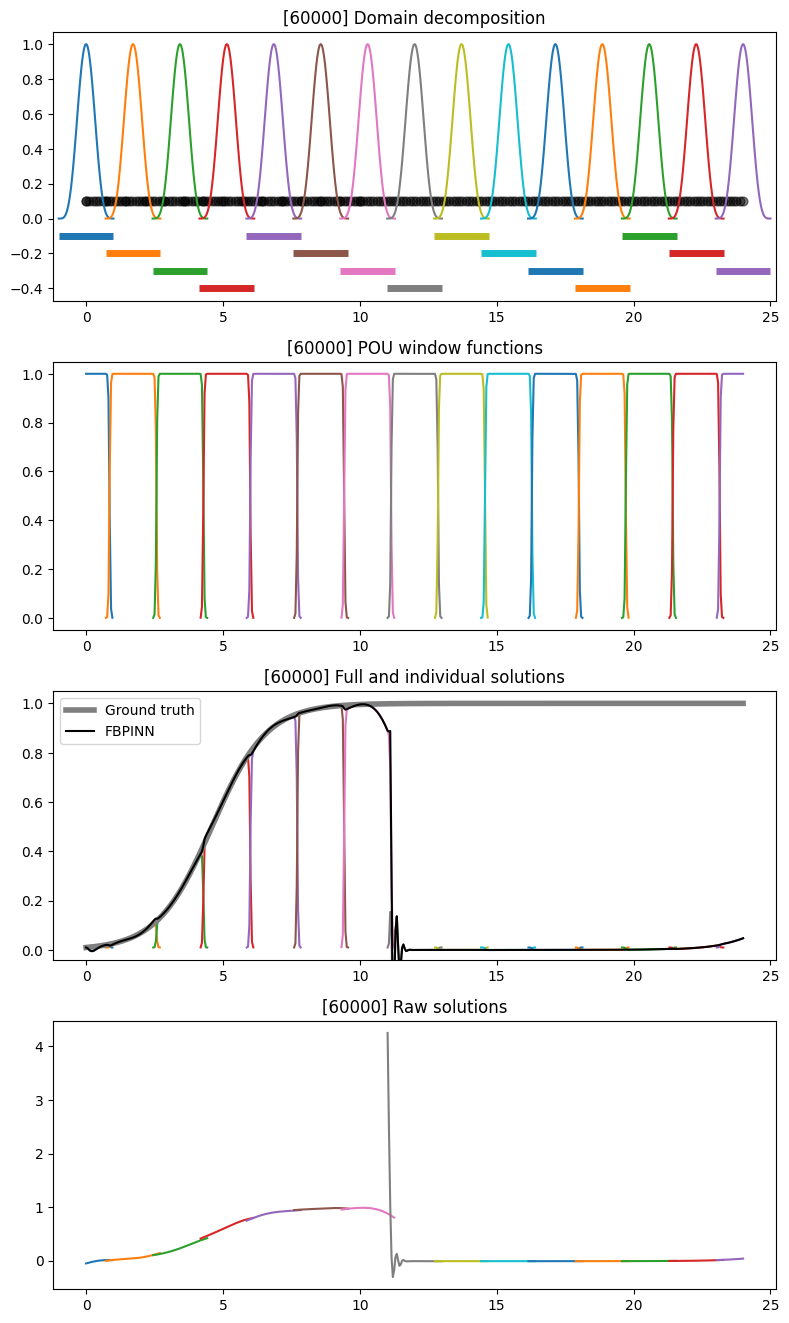

[INFO] 2024-02-14 01:46:46 - [i: 60000/60000] Training complete


In [31]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()

In [32]:
all_params["trainable"]["problem"]["C"]

Array(0.9722059, dtype=float32)